<a href="https://colab.research.google.com/github/siyusa/Contrastive-Learning/blob/main/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Contrastive Learning with SimCLR


In [ ]:
#os 模块提供了与操作系统交互的功能，如读取环境变量、管理文件和目录等
import os
# deepcopy 用于创建对象的深拷贝，即完全复制一个对象及其所有嵌套的内容，修改新对象不会影响原对象。
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
# 将 matplotlib 的默认色彩映射设置为 ‘cividis’。这是一种现代、感知均匀、对色盲友好的颜色方案，常用于科学出版物，能更好地呈现数据细节
plt.set_cmap('cividis')
# 这是一个 IPython 魔法命令（以 % 开头）。使 matplotlib 的图形能够直接嵌入在 Jupyter Notebook 中显示，而不是作为单独的窗口弹出
%matplotlib inline
# 设置 matplotlib 的输出格式为 SVG 和 PDF，这两种格式适合高质量的图形导出和打印
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
# 将绘图中所有线条的默认宽度设置为 2.0。这使得图表中的线条比默认值更粗、更清晰
matplotlib.rcParams['lines.linewidth'] = 2.0
# seaborn 是一个基于 matplotlib 的高级统计图形库和数据可视化库，提供更高级的接口和美观的默认样式。下面的代码导入 seaborn 并应用其默认样式设置
import seaborn as sns
# 激活 seaborn 的默认主题和样式设置，自动覆盖 matplotlib 原有的样式，使图表立即变得更具现代感和美观性（如更改背景、网格、字体、调色板等）
sns.set()

## tqdm for loading bars
# tqdm 是一个用于显示循环进度条的 Python 库，特别适合在长时间运行的任务中提供视觉反馈。下面的代码导入 tqdm 的 notebook 版本，以便在 Jupyter Notebook 环境中使用
from tqdm.notebook import tqdm

# PyTorch
import torch
# Torch 的神经网络模块，包含各种神经网络层、损失函数等
import torch.nn as nn
# Torch 的函数式接口，提供各种操作的无状态版本，如激活函数、卷积操作等
import torch.nn.functional as F
# Torch 的数据处理模块，包含数据集和数据加载器等
import torch.utils.data as data
# Torch 的优化器模块，包含各种优化算法，如 SGD、Adam 等
import torch.optim as optim

## Torchvision
# Torchvision 是 PyTorch 的一个子库，专注于计算机视觉任务，提供了常用的数据集、模型和图像变换工具
import torchvision
# torchvision 的数据集模块，包含常用的计算机视觉数据集，如 CIFAR10、ImageNet 等
from torchvision.datasets import STL10
# torchvision 的图像变换模块，提供各种图像预处理和数据增强操作
from torchvision import transforms

# PyTorch Lightning
# PyTorch Lightning 是一个用于简化 PyTorch 代码结构和训练流程的高层框架，旨在提高代码的可读性和可维护性，同时支持分布式训练等高级功能
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
# PyTorch Lightning 的回调模块，包含各种训练过程中的回调函数，如学习率监控、模型检查点等
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
# TensorBoard 是一个用于可视化机器学习实验的工具，常与 TensorFlow 和 PyTorch 一起使用。下面的代码导入 TensorBoard 的扩展，以便在 Jupyter Notebook 中使用
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Global seed set to 42


Device: cuda:0
Number of workers: 16


In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.GaussianBlur(kernel_size=9),
                                         ])

In [ ]:
class SimCLRUSDataset(Dataset):
    """
    Loads images under directory structure:
    data/<plane>/*.png
    Returns:
      x1, x2 : two augmented views for SimCLR (tensor [3,H,W], values in [0,1])
      enc   : weakly augmented masked image for encoder input ([1,H,W], values in [0,1])
      path  : original path
    """
    def __init__(self, root_dir='./data', size=512, data_transforms=None, n_views=2):
        self.root = Path(root_dir)
        exts = ('.png','.jpg','.jpeg','.bmp','.tiff','.tif')
        # 递归查找self.root目录及其所有子目录中，扩展名在exts集合中的所有文件，并按字母顺序返回它们的路径列表。
        self.samples = [p for p in sorted(self.root.rglob('*')) if p.suffix.lower() in exts] 
        self.size = size

        # Strong augmentations for SimCLR views
        self.base_transforms = data_transforms
        self.n_views = n_views
        self.augment2 = T.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
                                                  

    def __len__(self):
        return len(self.samples)
    


    def __getitem__(self, idx):
        p = self.samples[idx]
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise RuntimeError(f"Cannot read image: {p}")

        """
        x1 = self.base_transforms(img)  # [3,H,W], 
        x2 = self.base_transforms(img)

        plt.figure(figsize=(10,15))
        plt.title('Augmented image examples of the dataset')
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.imshow(x1.transpose(0,1).transpose(1,2))  # (c,h,w) to (h,w,c)
        plt.subplot(1,3,3)
        plt.imshow(x2.transpose(0,1).transpose(1,2))  
        plt.axis('off')
        plt.show()
        plt.close()
        """  

        return [self.base_transforms(img) for i in range(self.n_views)]


Finally, before starting with our implementation of SimCLR, let's look at some example image pairs sampled with our augmentations:

We see the wide variety of our data augmentation, including randomly cropping, grayscaling, gaussian blur, and color distortion. Thus, it remains a challenging task for the model to match two, independently augmented patches of the same image.

### SimCLR implementation

Using the data loader pipeline above, we can now implement SimCLR. At each iteration, we get for every image $x$ two differently augmented versions, which we refer to as $\tilde{x}_i$ and $\tilde{x}_j$. Both of these images are encoded into a one-dimensional feature vector, between which we want to maximize similarity which minimizes it to all other images in the batch. The encoder network is split into two parts: a base encoder network $f(\cdot)$, and a projection head $g(\cdot)$. The base network is usually a deep CNN as we have seen in e.g. [Tutorial 5](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html) before, and is responsible for extracting a representation vector from the augmented data examples. In our experiments, we will use the common ResNet-18 architecture as $f(\cdot)$, and refer to the output as $f(\tilde{x}_i)=h_i$. The projection head $g(\cdot)$ maps the representation $h$ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer. Note that in the follow-up paper, [SimCLRv2](https://arxiv.org/abs/2006.10029), the authors mention that larger/wider MLPs can boost the performance considerably. This is why we apply an MLP with four times larger hidden dimensions, but deeper MLPs showed to overfit on the given dataset. The general setup is visualized below (figure credit - [Ting Chen et al.](https://arxiv.org/abs/2006.10029)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_network_setup.svg?raw=1" width="350px"></center>

After finishing the training with contrastive learning, we will remove the projection head $g(\cdot)$, and use $f(\cdot)$ as a pretrained feature extractor. The representations $z$ that come out of the projection head $g(\cdot)$ have been shown to perform worse than those of the base network $f(\cdot)$ when finetuning the network for a new task. This is likely because the representations $z$ are trained to become invariant to many features like the color that can be important for downstream tasks. Thus, $g(\cdot)$ is only needed for the contrastive learning stage.

Now that the architecture is described, let's take a closer look at how we train the model. As mentioned before, we want to maximize the similarity between the representations of the two augmented versions of the same image, i.e., $z_i$ and $z_j$ in the figure above, while minimizing it to all other examples in the batch. SimCLR thereby applies the InfoNCE loss, originally proposed by [Aaron van den Oord et al.](https://arxiv.org/abs/1807.03748) for contrastive learning. In short, the InfoNCE loss compares the similarity of $z_i$ and $z_j$ to the similarity of $z_i$ to any other representation in the batch by performing a softmax over the similarity values. The loss can be formally written as:

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$

The function $\text{sim}$ is a similarity metric, and the hyperparameter $\tau$ is called temperature determining how peaked the distribution is. Since many similarity metrics are bounded, the temperature parameter allows us to balance the influence of many dissimilar image patches versus one similar patch. The similarity metric that is used in SimCLR is cosine similarity, as defined below:

$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

The maximum cosine similarity possible is $1$, while the minimum is $-1$. In general, we will see that the features of two different images will converge to a cosine similarity around zero since the minimum, $-1$, would require $z_i$ and $z_j$ to be in the exact opposite direction in all feature dimensions, which does not allow for great flexibility.

Finally, now that we have discussed all details, let's implement SimCLR below as a PyTorch Lightning module:

In [ ]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        # 保存所有传入的超参数到 self.hparams 字典中，便于日志记录和模型检查点保存
        self.save_hyperparameters()
        # 断言检查，确保温度参数为正数（负温度无意义）
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # 加载预训练的 ResNet18 模型，将最后全连接层输出改为 4*hidden_dim，作为Base model f(.) 
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        #  配置优化器和学习率调度器
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch   #imgs 的原始shape：类型：元组，包含2个张量, 每个张量shape：[batch_size, channels, height, width]
        imgs = torch.cat(imgs, dim=0) # [batch_size, C, H, W] × 2 → [2*batch_size, C, H, W]

        # Encode all images
        feats = self.convnet(imgs)   # feats: [2*batch_size, hidden_dim]
        # Calculate cosine similarity 计算所有特征对之间的余弦相似度矩阵
        # feats[:,None,:]: 形状 [2N, 1, D]; feats[None,:,:]: 形状 [1, 2N, D]; 结果: [2N, 2N] 相似度矩阵
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself 创建对角线掩码并填充极大负值. 排除每个样本与自身的相似度（softmax 中 exp(-9e15) ≈ 0）
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1) # InfoNCE 损失,l(i,j) = -log[exp(sim(zᵢ,zⱼ)/τ) / ∑ exp(sim(zᵢ,zₖ)/τ)]
        nll = nll.mean()

        # Logging loss
        self.log(mode+'_loss', nll)
        # 构建用于排名的相似度矩阵 Get ranking position of positive example
        # 每行第一列是该样本的正样本相似度，后面是其他所有样本（负样本）的相似度
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        # 计算正样本的排名:每行降序排序，获取索引。找到值0（第一列）在排序中的位置
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

### Training

Now that we have implemented SimCLR and the data loading pipeline, we are ready to train the model. We will use the same training function setup as usual. For saving the best model checkpoint, we track the metric `val_acc_top5`, which describes how often the correct image patch is within the top-5 most similar examples in the batch. This is usually less noisy than the top-1 metric, making it a better metric to choose the best model from.

In [ ]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        ds = SimCLRUSDataset(root_dir='./data', size=512, data_transforms = contrast_transforms,n_views = 2)
        train_loader = data.DataLoader(ds, batch_size=batch_size, shuffle=True,
                                       drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
        val_loader = data.DataLoader(train_data_contrast, batch_size=batch_size, shuffle=False,
                                     drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)
        pl.seed_everything(42) # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    return model

A common observation in contrastive learning is that the larger the batch size, the better the models perform. A larger batch size allows us to compare each image to more negative examples, leading to overall smoother loss gradients. However, in our case, we experienced that a batch size of 256 was sufficient to get good results.

In [ ]:
simclr_model = train_simclr(batch_size=256,
                            hidden_dim=128,
                            lr=5e-4,
                            temperature=0.07,
                            weight_decay=1e-4,
                            max_epochs=500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Found pretrained model at ../saved_models/tutorial17/SimCLR.ckpt, loading...


To get an intuition of how training with contrastive learning behaves, we can take a look at the TensorBoard below:

In [ ]:
%tensorboard --logdir ../saved_models/tutorial17/tensorboards/SimCLR/

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/tensorboard_simclr.png?raw=1" width="1200px"></center>

One thing to note is that contrastive learning benefits a lot from long training. The shown plot above is from a training that took approx. 1 day on a NVIDIA TitanRTX. Training the model for even longer might reduce its loss further, but we did not experience any gains from it for the downstream task on image classification. In general, contrastive learning can also benefit from using larger models, if sufficient unlabeled data is available.

## Logistic Regression

After we have trained our model via contrastive learning, we can deploy it on downstream tasks and see how well it performs with little data. A common setup, which also verifies whether the model has learned generalized representations, is to perform Logistic Regression on the features. In other words, we learn a single, linear layer that maps the representations to a class prediction. Since the base network $f(\cdot)$ is not changed during the training process, the model can only perform well if the representations of $h$ describe all features that might be necessary for the task. Further, we do not have to worry too much about overfitting since we have very few parameters that are trained. Hence, we might expect that the model can perform well even with very little data.

First, let's implement a simple Logistic Regression setup for which we assume that the images already have been encoded in their feature vectors. If very little data is available, it might be beneficial to dynamically encode the images during training so that we can also apply data augmentations. However, the way we implement it here is much more efficient and can be trained within a few seconds. Further, using data augmentations did not show any significant gain in this simple setup.

In [ ]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

The data we use is the training and test set of STL10. The training contains 500 images per class, while the test set has 800 images per class.

In [ ]:
img_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_img_data = STL10(root=DATASET_PATH, split='train', download=True,
                       transform=img_transforms)
test_img_data = STL10(root=DATASET_PATH, split='test', download=True,
                      transform=img_transforms)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 5000
Number of test examples: 8000


Next, we implement a small function to encode all images in our datasets. The output representations are then used as inputs to the Logistic Regression model.

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

Let's apply the function to both training and test set below.

In [ ]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/125 [00:00<?, ?it/s]

Finally, we can write a training function as usual. We evaluate the model on the test set every 10 epochs to allow early stopping, but the low frequency of the validation ensures that we do not overfit too much on the test set.

In [ ]:
def train_logreg(batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,
                         check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

Despite the training dataset of STL10 already only having 500 labeled images per class, we will perform experiments with even smaller datasets. Specifically, we train a Logistic Regression model for datasets with only 10, 20, 50, 100, 200, and all 500 examples per class. This gives us an intuition on how well the representations learned by contrastive learning can be transfered to a image recognition task like this classification. First, let's define a function to create the intended sub-datasets from the full training set:

In [ ]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[t.unflatten(0, (10, -1))[:,:num_imgs_per_label].flatten(0, 1) for t in original_dataset.tensors]
    )
    return new_dataset

Next, let's run all models. Despite us training 6 models, this cell could be run within a minute or two without the pretrained models.

In [ ]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(batch_size=64,
                                        train_feats_data=sub_train_set,
                                        test_feats_data=test_feats_simclr,
                                        model_suffix=num_imgs_per_label,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=1e-3,
                                        weight_decay=1e-3)
    results[num_imgs_per_label] = small_set_results

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)
/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_10.ckpt, loading...
Found pretrained model at ../saved_models/tutorial17/LogisticRegression_20.ckpt, loading...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_50.ckpt, loading...
Found pretrained model at ../saved_models/tutorial17/LogisticRegression_100.ckpt, loading...


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_200.ckpt, loading...
Found pretrained model at ../saved_models/tutorial17/LogisticRegression_500.ckpt, loading...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finally, let's plot the results.

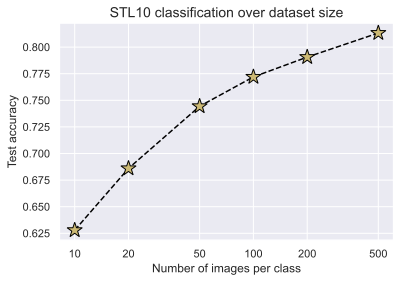

Test accuracy for  10 images per label: 62.79%
Test accuracy for  20 images per label: 68.60%
Test accuracy for  50 images per label: 74.44%
Test accuracy for 100 images per label: 77.20%
Test accuracy for 200 images per label: 79.06%
Test accuracy for 500 images per label: 81.33%


In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f'Test accuracy for {k:3d} images per label: {100*score:4.2f}%')

As one would expect, the classification performance improves the more data we have. However, with only 10 images per class, we can already classify more than 60% of the images correctly. This is quite impressive, considering that the images are also higher dimensional than e.g. CIFAR10. With the full dataset, we achieve an accuracy of 81%. The increase between 50 to 500 images per class might suggest a linear increase in performance with an exponentially larger dataset. However, with even more data, we could also finetune $f(\cdot)$ in the training process, allowing for the representations to adapt more to the specific classification task given.

To set the results above into perspective, we will train the base network, a ResNet-18, on the classification task from scratch.

## Baseline

As a baseline to our results above, we will train a standard ResNet-18 with random initialization on the labeled training set of STL10. The results will give us an indication of the advantages that contrastive learning on unlabeled data has compared to using only supervised training. The implementation of the model is straightforward since the ResNet architecture is provided in the torchvision library.

In [ ]:
class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.7),
                                                                  int(self.hparams.max_epochs*0.9)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='test')

It is clear that the ResNet easily overfits on the training data since its parameter count is more than 1000 times larger than the dataset size. To make the comparison to the contrastive learning models fair, we apply data augmentations similar to the ones we used before: horizontal flip, crop-and-resize, grayscale, and gaussian blur. Color distortions as before are not used because the color distribution of an image showed to be an important feature for the classification. Hence, we observed no noticeable performance gains when adding color distortions to the set of augmentations. Similarly, we restrict the resizing operation before cropping to the max. 125% of its original resolution, instead of 1250% as done in SimCLR. This is because, for classification, the model needs to recognize the full object, while in contrastive learning, we only want to check whether two patches belong to the same image/object. Hence, the chosen augmentations below are overall weaker than in the contrastive learning case.

In [ ]:
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))
                                       ])

train_img_aug_data = STL10(root=DATASET_PATH, split='train', download=True,
                           transform=train_transforms)

Files already downloaded and verified


The training function for the ResNet is almost identical to the Logistic Regression setup. Note that we allow the ResNet to perform validation every 2 epochs to also check whether the model overfits strongly in the first iterations or not.

In [ ]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=2)
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(train_img_aug_data, batch_size=batch_size, shuffle=True,
                                   drop_last=True, pin_memory=True, num_workers=NUM_WORKERS)
    test_loader = data.DataLoader(test_img_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=NUM_WORKERS)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

Finally, let's train the model and check its results:

In [ ]:
resnet_model, resnet_result = train_resnet(batch_size=64,
                                           num_classes=10,
                                           lr=1e-3,
                                           weight_decay=2e-4,
                                           max_epochs=100)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Found pretrained model at ../saved_models/tutorial17/ResNet.ckpt, loading...


/home/phillip/anaconda3/envs/dl2020/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:00, ?it/s]

Accuracy on training set: 99.76%
Accuracy on test set: 73.31%


The ResNet trained from scratch achieves 73.31% on the test set. This is almost 8% less than the contrastive learning model, and even slightly less than SimCLR achieves with 1/10 of the data. This shows that self-supervised, contrastive learning provides considerable performance gains by leveraging large amounts of unlabeled data when little labeled data is available.

## Conclusion

In this tutorial, we have discussed self-supervised contrastive learning and implemented SimCLR as an example method. We have applied it to the STL10 dataset and showed that it can learn generalizable representations that we can use to train simple classification models. With 500 images per label, it achieved an 8% higher accuracy than a similar model solely trained from supervision and performs on par with it when only using a tenth of the labeled data. Our experimental results are limited to a single dataset, but recent works such as [Ting Chen et al.](https://arxiv.org/abs/2006.10029) showed similar trends for larger datasets like ImageNet. Besides the discussed hyperparameters, the size of the model seems to be important in contrastive learning as well. If a lot of unlabeled data is available, larger models can achieve much stronger results and come close to their supervised baselines. Further, there are also approaches for combining contrastive and supervised learning, leading to performance gains beyond supervision (see [Khosla et al.](https://arxiv.org/abs/2004.11362)). Moreover, contrastive learning is not the only approach to self-supervised learning that has come up in the last two years and showed great results. Other methods include distillation-based methods like [BYOL](https://arxiv.org/abs/2006.07733) and redundancy reduction techniques like [Barlow Twins](https://arxiv.org/abs/2103.03230). There is a lot more to explore in the self-supervised domain, and more, impressive steps ahead are to be expected.

### References

[1] Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. (2020). A simple framework for contrastive learning of visual representations. In International Conference on Machine Learning (ICML 2020). PMLR. ([link](https://arxiv.org/abs/2002.05709))

[2] Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. (2020). Big self-supervised models are strong semi-supervised learners. NeurIPS 2021 ([link](https://arxiv.org/abs/2006.10029)).

[3] Oord, A. V. D., Li, Y., and Vinyals, O. (2018). Representation learning with contrastive predictive coding. arXiv preprint arXiv:1807.03748. ([link](https://arxiv.org/abs/1807.03748))

[4] Grill, J.B., Strub, F., Altché, F., Tallec, C., Richemond, P.H., Buchatskaya, E., Doersch, C., Pires, B.A., Guo, Z.D., Azar, M.G. and Piot, B. (2020). Bootstrap your own latent: A new approach to self-supervised learning. NeurIPS 2020 ([link](https://arxiv.org/abs/2006.07733))

[5] Khosla, P., Teterwak, P., Wang, C., Sarna, A., Tian, Y., Isola, P., Maschinot, A., Liu, C. and Krishnan, D. (2020). Supervised contrastive learning. NeurIPS 2020 ([link](https://arxiv.org/abs/2004.11362))

[6] Zbontar, J., Jing, L., Misra, I., LeCun, Y. and Deny, S. (2021). Barlow twins: Self-supervised learning via redundancy reduction. In International Conference on Machine Learning (ICML 2021). ([link](https://arxiv.org/abs/2103.03230))

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub.

---